In [1]:
import os
import pickle

from graph_traffic.dataloading import graph_dataset, npzDataset
from graph_traffic.dcrnn import DiffConv
from graph_traffic.config import project_path
from graph_traffic.model import GraphRNN
from graph_traffic.train import train, eval, predict
from graph_traffic.utils import NormalizationLayer, masked_mae_loss
from graph_traffic.get_data import get_data, plot_graph

import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('Agg')

from datetime import datetime
from torch.utils.data import DataLoader
import dgl
import torch
from functools import partial

training_time = datetime.now().strftime("%Y%m%d_%H%M%S")
print(training_time)

C:\Users\Bened\PycharmProjects\madrid-traffic\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


20220520_142259


## 0. Define training parameters

In [2]:
args = dict(
    n_points=None,
    batch_size=64,
    diffsteps=2,
    decay_steps=2000,
    lr=0.01,
    minimum_lr=2e-6,
    epochs=100,
    max_grad_norm=5.0,
    num_workers=0,
    model="dcrnn",
    gpu=-1,
    num_heads=2, # relevant for model="gaan"
    out_feats=1*64,
    num_layers=2
)

n_points = args["n_points"]
batch_size = args["batch_size"]
diffsteps = args["diffsteps"]
decay_steps = args["decay_steps"]
lr = args["lr"]
minimum_lr = args["minimum_lr"]
epochs = args["epochs"]
max_grad_norm = args["max_grad_norm"]
num_workers = args["num_workers"]
model = args["model"]
gpu = args["gpu"]
num_heads = args["num_heads"]
out_feats = args["out_feats"]
num_layers = args["num_layers"]


In [3]:
if gpu == -1:
    device = torch.device('cpu')
else:
    device = torch.device('cuda:{}'.format(gpu))

## 1. Load data

In [4]:
data_dict = dict(
    ids_list=[1001, 1002, 1003],#[3954, 3973],#, 3976, 3977, 3978],

    seq_len=12,
    with_graph=True,
    from_date="2019-01-01",
    to_date="2019-01-31",
    dataset_name="small",
    target="intensidad",  # 1
    interactions="drop"
)

meteo_dict = dict(
    rain="drop",  # 1
    wind="drop",
    temperature="drop",  # 0
    humidity="drop",  # 1
    pressure="drop",  # 0
    radiation="drop"  # 0
)

temporal_dict = dict(
    season="drop",
    month="drop",
    day_of_month="drop",
    hour="drop",
    bank_holiday="drop",
    working_day="drop",
    school_holiday="drop",
    minute="drop",
    year="drop",
    weekday="drop"
)

ids_list = data_dict["ids_list"]
rain = meteo_dict["rain"]
wind = meteo_dict["wind"]
season = temporal_dict["season"]
month = temporal_dict["month"]
day_of_month = temporal_dict["day_of_month"]
hour = temporal_dict["hour"]
interactions = data_dict["interactions"]
seq_len = data_dict["seq_len"]
with_graph = data_dict["with_graph"]
from_date = data_dict["from_date"]
to_date = data_dict["to_date"]
dataset_name = data_dict["dataset_name"]

### Save variables in text file for the records

In [5]:
training_folder = f"{project_path}/training_history/{training_time}"
os.mkdir(training_folder)
with open(f"{training_folder}/learning_args.pkl", "wb") as f:
    pickle.dump(args, f)
with open(f"{training_folder}/data_dict.pkl", "wb") as f:
    pickle.dump(data_dict, f)
with open(f"{training_folder}/meteo_dict.pkl", "wb") as f:
    pickle.dump(meteo_dict, f)
with open(f"{training_folder}/temporal_dict.pkl", "wb") as f:
    pickle.dump(temporal_dict, f)

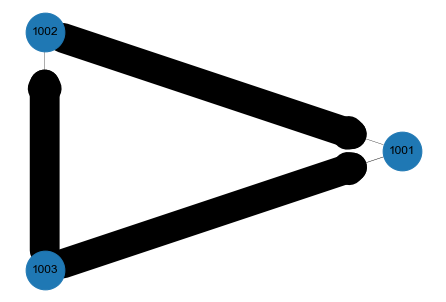

In [6]:
x, y, g = get_data(data_dict, meteo_dict, temporal_dict)
plot_graph(g, ids_list, save_dir=training_folder)

In [7]:
g.edata

{'weight': tensor([0.0110, 0.0150, 0.9938, 0.0108, 0.9772, 0.9946], dtype=torch.float64)}

In [8]:
dataset_name = "metr_la"
# n_points=1000
g = graph_dataset(dataset_name)
train_data = npzDataset(dataset_name, "train", n_points)
test_data = npzDataset(dataset_name, "test", n_points)
#valid_data = npzDataset(dataset_name, "valid", n_points)

seq_len = train_data.x.shape[1]
in_feats = train_data.x.shape[-1]

In [9]:
train_data.x.shape, train_data.y.shape

((23974, 12, 207, 2), (23974, 12, 207, 2))

In [10]:
test_data.x.shape, test_data.y.shape

((6850, 12, 207, 2), (6850, 12, 207, 2))

In [11]:
train_loader = DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
#valid_loader = DataLoader(
#    valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

normalizer = NormalizationLayer(train_data.min, train_data.max)

In [12]:
train_data.x.shape

(23974, 12, 207, 2)

## 2. Define the model

In [13]:
if model == "dcrnn":
    batch_g = dgl.batch([g] * batch_size).to(device)
    out_gs, in_gs = DiffConv.attach_graph(batch_g, diffsteps)
    net = partial(DiffConv, k=diffsteps, in_graph_list=in_gs, out_graph_list=out_gs)
elif model == 'gaan':
    print("not available")

dcrnn = GraphRNN(in_feats=in_feats,
                 out_feats=out_feats,
                 seq_len=seq_len,
                 num_layers=num_layers,
                 net=net,
                 decay_steps=decay_steps).to(device)

## 3. Define learning parameters

In [14]:
optimizer = torch.optim.Adam(dcrnn.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

loss_fn = masked_mae_loss

## 4. Train model

Después de hacer el cambio sigmoid -> tanh

In [ ]:
train_losses = []
#valid_losses = []
test_losses = []
for e in range(epochs):
    train(dcrnn, g, train_loader, optimizer, scheduler, normalizer, loss_fn, device, batch_size, max_grad_norm, minimum_lr)
    train_loss = eval(dcrnn, g, train_loader, normalizer, loss_fn, device, batch_size)
    #valid_loss = eval(dcrnn, g, valid_loader, normalizer, loss_fn, device, batch_size)
    test_loss = eval(dcrnn, g, test_loader, normalizer, loss_fn, device, batch_size)
    print(f"Epoch: {e} Train Loss: {train_loss} Test Loss: {test_loss}")

    train_losses.append(train_loss)
    #valid_losses.append(valid_loss)
    test_losses.append(test_loss)

    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(train_losses, label="train")
    #ax.plot(valid_losses, label="validation")
    ax.plot(test_losses, label="test")
    plt.legend()
    plt.savefig(f"{training_folder}/learning_curve.svg")
    plt.close(fig)

C:\Users\Bened\PycharmProjects\madrid-traffic\env\lib\site-packages\torch\autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [ ]:
os.mkdir(f"{training_folder}/losses")
with open(f"{training_folder}/losses/train.pkl", "wb") as f:
    pickle.dump(train_losses, f)
#with open(f"{training_folder}/losses/valid.pkl", "wb") as f:
#    pickle.dump(valid_losses, f)
with open(f"{training_folder}/losses/test.pkl", "wb") as f:
    pickle.dump(test_losses, f)

## 5. Save model

In [ ]:
torch.save(dcrnn.state_dict(), f"{training_folder}/model.pt")

## 6. Try model

In [ ]:
matplotlib.use("TkAgg")

In [ ]:
for i, (x, y) in enumerate(train_loader):
    #x, y, x_norm, y_norm, batch_graph = prepare_data(g.to(device), x, y, normalizer, args.batch_size, device)
    #y_pred = predict(dcrnn, batch_graph, x_norm, y_norm, normalizer, device, i)
    dcrnn.eval()
    y, y_pred = predict(x, y, batch_size, g.to(device), dcrnn, device, normalizer)
    break

for i in range(10):
    fig, ax = plt.subplots()
    #ax.set_title(f"de {(y[:, i, 1]*24).min().numpy()} a  {(y[:, i, 1]*24).max().numpy()}, sensor{i%5+1}")
    ax.plot(y[:, i, 0].detach().numpy(), label="real")
    ax.plot(y_pred[:, i, 0].detach().numpy(), label="pred")
    plt.legend()

In [ ]:
plt.scatter(y.detach().numpy().ravel(), y_pred.detach().numpy().ravel())
plt.show()

In [ ]:
for i, (x, y) in enumerate(valid_loader):
    #x, y, x_norm, y_norm, batch_graph = prepare_data(g.to(device), x, y, normalizer, args.batch_size, device)
    #y_pred = predict(dcrnn, batch_graph, x_norm, y_norm, normalizer, device, i)
    dcrnn.eval()
    y, y_pred = predict(x, y, batch_size, g.to(device), dcrnn, device, normalizer)
    break
plt.scatter(y.detach().numpy().ravel(), y_pred.detach().numpy().ravel())

In [ ]:
for i, (x, y) in enumerate(test_loader):
    #x, y, x_norm, y_norm, batch_graph = prepare_data(g.to(device), x, y, normalizer, args.batch_size, device)
    #y_pred = predict(dcrnn, batch_graph, x_norm, y_norm, normalizer, device, i)
    dcrnn.eval()
    y, y_pred = predict(x, y, batch_size, g.to(device), dcrnn, device, normalizer)
    break
plt.scatter(y.detach().numpy().ravel(), y_pred.detach().numpy().ravel())